# Solutions to exercise in 2_regression

In [1]:
# Import required packages

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize) 
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

C:\Users\tthivillon\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\tthivillon\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### 13.(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [2]:
# Load Weekly dataset

Weekly = load_data('Weekly')
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


Text(0.5, 0, 'Week')

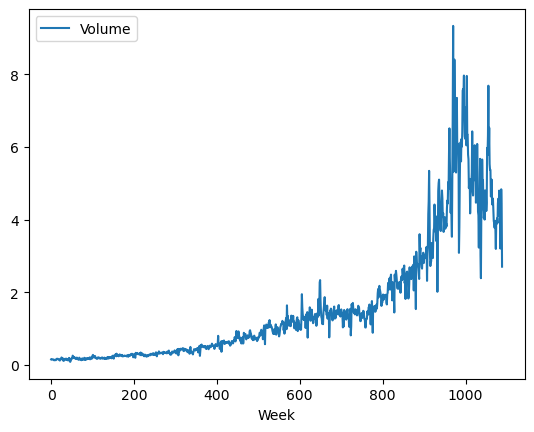

In [3]:
# Plot the volume over time for the 1,089 weeks
plot = Weekly.plot(y='Volume')
plot.set_xlabel('Week')

The weekly volume of traded shares increased continuously during the study period (except during the last 100 weeks). The growth seems to follow an exponential function.

#### 13.(b) Use the full data set to perform a logistic regression with 'Direction' as the response and the five lag variables plus 'Volume' as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [4]:
#Perform requested logistic regression using GLM package
myvars = Weekly.columns.drop(['Today', 'Direction', 'Year']) 
design = MS(myvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up' 
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
results.summary() #Print results using summary function

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Tue, 05 Nov 2024   Deviance:                       1486.4
Time:                        14:37:38   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

The coefficient on Lag2 is statistically significant at the 5% level (p-value = 0.03).

#### 13.(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [5]:
#Generate predicted probability that Direction = 'Up' for each week
pred = results.predict()
labels = np.array(['Down']*1089)
labels[pred>0.5] = "Up"
#Print confusion table
confusion_table(labels, Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [6]:
np.mean(labels == Weekly.Direction) #Compute fraction of correct predictions

0.5610651974288338

The fraction of correct predictions is 56%. In addition, we can see that the model has a much higher accuracy rate when predicting the 'Up' direction than when predicting the 'Down' direction:

In [7]:
#Compute prediction accuracy rate by observed value of 'Direction' using Python programming rather than by hand
dfcorrect = pd.DataFrame(data = labels, columns = ['Predicted']) 
dfcorrect = Weekly.join(dfcorrect)
dfcorrect['Correct'] = np.where(dfcorrect['Direction'] == dfcorrect['Predicted'], True, False)
dfcorrect['Correct'] = dfcorrect['Correct'].astype(int)
accuracy_rates = dfcorrect.groupby('Direction', observed = True)['Correct'].mean()
print(accuracy_rates)

Direction
Down    0.111570
Up      0.920661
Name: Correct, dtype: float64


#### 13.(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with 'Lag2' as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [8]:
#Generate training and test data frames
train = (Weekly.Year < 2009)
Weekly_train = Weekly.loc[train]
Weekly_test = Weekly.loc[~train]
Weekly_test.shape

(104, 9)

In [9]:
#Fit logistic regression with the training data with Lag2 as the only predictor
X = MS(['Lag2']).fit_transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [10]:
#Compare the predictions for 2009-2010 to the movement observed in the data for the same period
D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

#Print confusion table 
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [11]:
#Compute fraction of correct predictions
np.mean(labels == L_test)

0.625

#### 13.(g) Repeat (d) using KNN with K = 1.

In [12]:
# Fit the KNN classifier using the fit method
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)

#Perform predictions using the predict method
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


#### 13.(i) Which of these methods appears to provide the best results on this data?

In [13]:
np.mean(knn1_pred == L_test)

0.5

Logistic regression has much higher prediction accuracy (0.625) than KNN with K = 1 (0.5) on this data.